다중 분류 모델
===
채팅 대화문에서 날짜, 품목, 위치, 가격 추출
---

----------

## 0. Model Flowchart

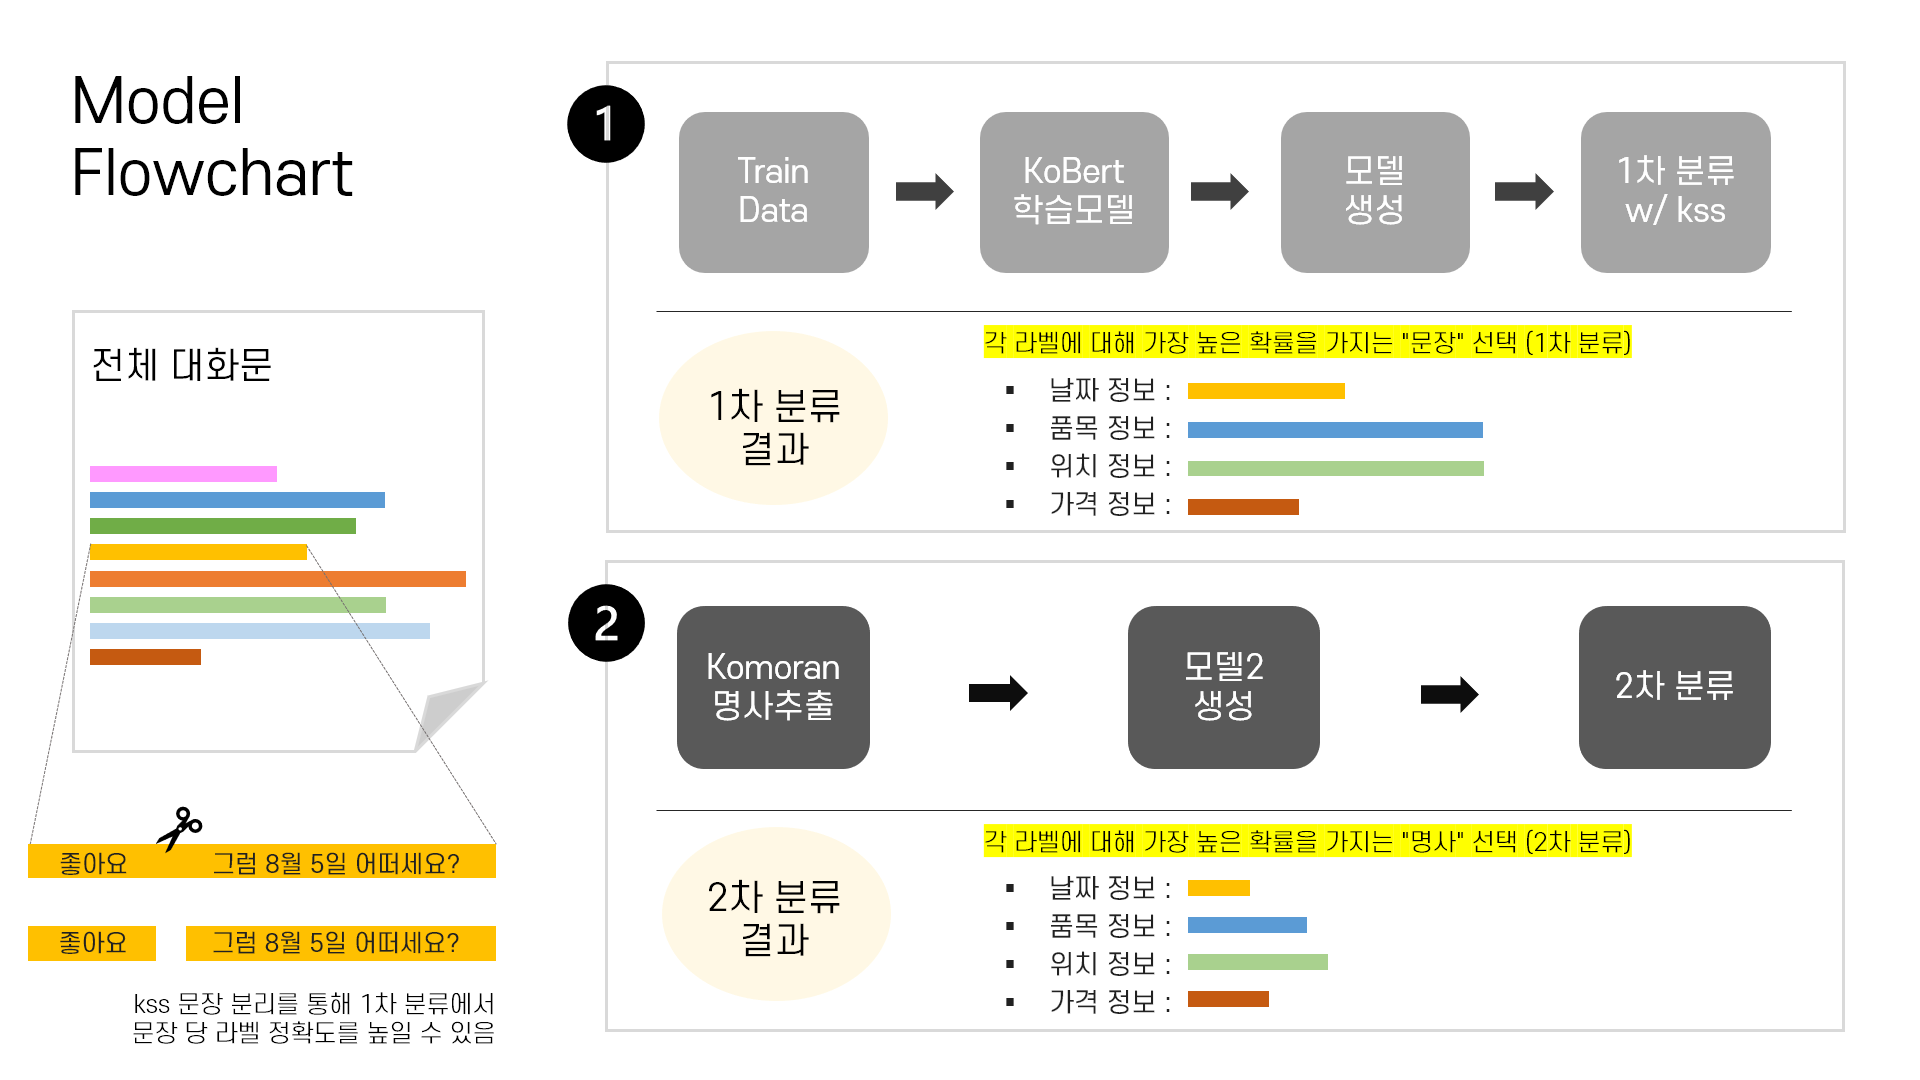

## 0. 분석 과정 설명

1. `ClassifierModule` 클래스의 인스턴스 생성 -> `words_sorting` 함수 호출


2. 문장 리스트에 대해 다중 분류 수행 : 정확도를 비교하여 가장 높은 값을 가진 sentence 하나만 각 label에 배정됨(`sorting` 함수)  
     * ex) 날짜 정보 : 6월 8일에 봐요
     * ex) 품목 정보 : 노트북 사려구요
     * ex) 위치 정보 : 서울역 8번출구에서 봐요
     * ex) 가격 정보 : 9만원으로 하죠
     
     
3. 날짜,품목,위치의 경우 label이 배정된 문장들에 대해 형태소 분석을 수행하여 명사만 뽑아 명사 리스트 생성 (`sentence_to_words` 함수)
     * 사용자 사전에 추가된 단어가 이 때 함께 추출됨
     * ex) ['6월 8일', '노트북', '서울역', '번', '출구']
     
     
4. 가격의 경우 정규표현식으로 추출하여 추출된 단어가 전달됨
     * ex) "9만원으로 하죠" => "9만원" 추출
     
     
5. 리스트 내 각 단어에 대해 다중 분류 수행, label 당 최종 단어 채택
     * ex) 날짜 정보 :  6월 8일
     * ex) 품목 정보 :  노트북
     * ex) 위치 정보 :  서울역
     * ex) 가격 정보 :  9만원   



---





## 1. 필요한 모듈 임포트부터 KoBert 학습 모델 저장까지

In [ ]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# requirements 다운로드
!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers==3.0.2
!pip install torch
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master
!pip install konlpy
!pip install PyKomoran
!pip install kss

     |████████████████████████████████| 46.9 MB 43 kB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 344 kB 8.9 MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp37-cp37m-linux_x86_64.whl size=595725 sha256=4dda785e6807e25b481fdcbb0adb378d67b5c6f131dc54afb493044879a8cbbf
  Stored in directory: /root/.cache/pip/wheels/be/b4/06/7f3fdfaf707e6b5e98b79c041e023acffbe395d78a527eae00
Successfully built gluonnlp
     |████████████████████████████████| 1.2 MB 7.3 MB/s 
     |████████████████████████████████| 769 kB 7.9 MB/s 
     |████████████████████████████████| 895 kB 44.4 MB/s 
     |████████████████████████████████| 3.0 MB 41.7 MB/s 
  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-mxsjqp8c
  Running command git clone -q 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pip

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup
import re
from konlpy.tag import Komoran
import kss

[Korean Sentence Splitter]: Initializing Kss...


In [ ]:
# 사용자 사전
komoran = Komoran(userdic='/content/drive/MyDrive/Colab Notebooks/user_dic2.txt')

In [ ]:
# GPU 사용
device = torch.device('cpu')

In [ ]:
bertmodel, vocab = get_pytorch_kobert_model()

[██████████████████████████████████████████████████]
[██████████████████████████████████████████████████]


In [ ]:
data= pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Data/raw_800.xlsx')
data.loc[(data['label'] == "날짜"), 'label'] = 0; data.loc[(data['label'] == "위치"), 'label'] = 1; data.loc[(data['label'] == "품목"), 'label'] = 2; data.loc[(data['label'] == "가격"), 'label'] = 3
data_list = []
for q, label in zip(data['text'], data['label'])  :
    data = []
    data.append(q)
    data.append(str(label))
    data_list.append(data)
dataset_train, dataset_test = train_test_split(data_list, test_size=0.2, random_state=999)

class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [ ]:
# 하이퍼 파라미터
max_len = 64
batch_size = 64
warmup_ratio = 0.1
num_epochs = 10
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [ ]:
# 토큰화
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)
data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, max_len, True, False)

using cached model


In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=4,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate

        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)

    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)

        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [ ]:
PATH = "/content/drive/MyDrive/Colab Notebooks/kobertModel_v0728.pt"
model = torch.load(PATH, map_location=torch.device('cpu'))
model.eval()

BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(8002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True

---------------------

## 2. 1차 분류 모델 생성

In [ ]:
#토큰화
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

using cached model


In [ ]:
#문장분리를 위한 kss
def KSS(sent):
  kss_sent = []
  for i in sent:
    j = kss.split_sentences(i)
    kss_sent.extend(j)
  print('원본 텍스트:', sent)
  print('분리 텍스트:', kss_sent)
  return kss_sent

In [ ]:
def predict2(sent):
    data = [sent, '0']
    dataset_another = [data]
    another_test = BERTDataset(dataset_another, 0, 1, tok, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_eval=[]
        for i in out:
            logits = i
            logits = logits.detach().cpu().numpy()
            if np.argmax(logits) == 0:
                test_eval.append("날짜")
            elif np.argmax(logits) == 1:
                test_eval.append("위치")
            elif np.argmax(logits) == 2:
                test_eval.append("품목")
            elif np.argmax(logits) == 3:
                test_eval.append("가격")
        return test_eval[0], out

----------

## 3. 2차 분류 모델

In [ ]:
class ClassifierModule():

  def __init__(self):
    self.text = ""

    self.date_sent = ""
    self.item_sent = ""
    self.place_sent = ""
    self.price_sent = ""

    self.words = []

    self.date_word = ""
    self.item_word = ""
    self.place_word = ""
    self.price_word = ""


  def sentence_to_words(self):                                 ## 선정된 문장에 대해 명사만 추출하여 리스트 생성
    self.words = komoran.nouns(self.date_sent) + komoran.nouns(self.item_sent) + komoran.nouns(self.place_sent)
    print(self.words)

  def sorting(self):                                     ## 전체 문장 리스트에 대해 정확도가 가장 높은 문장 분류
    date_max = -1
    item_max = -1
    place_max = -1
    price_max = -1

    for sent in self.text:
      test_eval, out = predict2(sent)
      max_val, max_index = torch.max(out, 1)
      #print(sent)
      #print(max_val)
      #print("\n")

      if test_eval == '날짜':
        if date_max < max_val:
          self.date_sent = sent
          date_max = max_val
      elif test_eval=='품목':
        if item_max < max_val:
          item_max = max_val
          self.item_sent = sent
      elif test_eval =='위치':
        if place_max < max_val:
          place_max = max_val
          self.place_sent = sent
      elif test_eval =='가격':
        if price_max < max_val:
          self.price_sent = sent


    print(
      '* * * 1차 분류 결과 * * * ',
      '\n날짜 정보 : ', self.date_sent,
      '\n품목 정보 : ', self.item_sent,
      '\n위치 정보 : ', self.place_sent,
      '\n가격 정보 : ', self.price_sent)


  def final_check(self):
    if self.price_word == "":
      money_regex = re.compile("\d+(원|만원|마넌)|\d+만|만원|\d+.\d(만원|만)?")
      for sent in self.text:
        result = money_regex.search(sent)
        if result:
          self.price_word = result.group(0)

  def words_sorting(self, text):                                     ## 명사 리스트 중에서 가장 정확도가 높은 명사 분류
    self.text = text
    self.sorting()
    self.sentence_to_words()
    date_max = -1
    item_max = -1
    place_max = -1
    price_max = -1
    for word in self.words:
      test_eval, out = predict2(word)
      max_val, max_index = torch.max(out, 1)
      #print(word)
      #print(max_val)
      #print("\n")

      if test_eval == '날짜':
        if self.date_word == "" and date_max < max_val:
          self.date_word = word
          date_max = max_val
      elif test_eval=='품목':
        if item_max < max_val:
          self.item_word = word
          item_max = max_val
      elif test_eval =='위치':
        if place_max < max_val:
          self.place_word = word
          place_max = max_val

    #정규표현식을 통한 실제 가격 추출
    money_regex = re.compile("\d+(원|만원|마넌)|\d+만|만원|\d+.\d(만원|만)?")
    result = money_regex.search(self.price_sent)
    if result:
      self.money_word = result.group(0)

    self.final_check()

    print(' ')
    print(
      '* * * 2차 분류 결과 * * * ',
      '\n날짜 정보 : ', self.date_word,
      '\n품목 정보 : ', self.item_word,
      '\n위치 정보 : ', self.place_word,
      '\n가격 정보 : ', self.price_word)

---------------

## 4. 테스트

In [ ]:
sent1 = ['안녕하세요',
        '네 안녕하세요',
        '물건 파시는 분 맞으시죠',
        '네네 자전거 캐논데일 사고싶어용',
        '서울역 근방에서 보시죠',
        '좋아요',
        '네',
        '얼마죠?',
        '네6만원입니다',
        '다음주 수요일에 거래 어떠세요?',
        '좋아요 그때 뵈요']

sent1 = KSS(sent1)
CM = ClassifierModule()
CM.words_sorting(sent1)

원본 텍스트: ['안녕하세요', '네 안녕하세요', '물건 파시는 분 맞으시죠', '네네 자전거 캐논데일 사고싶어용', '서울역 근방에서 보시죠', '좋아요', '네', '얼마죠?', '네6만원입니다', '다음주 수요일에 거래 어떠세요?', '좋아요 그때 뵈요']
분리 텍스트: ['안녕하세요', '네 안녕하세요', '물건 파시는 분 맞으시죠', '네네 자전거 캐논데일 사고싶어용', '서울역 근방에서 보시죠', '좋아요', '네', '얼마죠?', '네6만원입니다', '다음주 수요일에 거래 어떠세요?', '좋아요', '그때 뵈요']


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


* * * 1차 분류 결과 * * *  
날짜 정보 :  다음주 수요일에 거래 어떠세요? 
품목 정보 :  네네 자전거 캐논데일 사고싶어용 
위치 정보 :  서울역 근방에서 보시죠 
가격 정보 :  네6만원입니다
['다음', '주', '수요일', '거래', '네네', '자전거', '캐논', '데일', '서울역', '근방']
 
* * * 2차 분류 결과 * * *  
날짜 정보 :  수요일 
품목 정보 :  자전거 
위치 정보 :  서울역 
가격 정보 :  6만원


In [ ]:
sent2 = ["ㅎㅇ",
         "네 ㅎㅇ",
         "갤럭시 S10 아직 파시나요",
         "네 아직 안팔렸어요",
         "상태 좋나요?",
         "네 산지 얼마 안됐어요",
         "살게요, 11만원 어때요?",
         "네 강남역에서 직거래 하죠",
         "네 저는 내일 15시 괜찮습니다",
         "음 저 그때는 회사에 있어서... 이틀 뒤는 괜찮으신가요?",
         "네 그때 봐요"]

sent2 = KSS(sent2)
CM2 = ClassifierModule()
CM2.words_sorting(sent2)

원본 텍스트: ['ㅎㅇ', '네 ㅎㅇ', '갤럭시 S10 아직 파시나요', '네 아직 안팔렸어요', '상태 좋나요?', '네 산지 얼마 안됐어요', '살게요, 11만원 어때요?', '네 강남역에서 직거래 하죠', '네 저는 내일 15시 괜찮습니다', '음 저 그때는 회사에 있어서... 이틀 뒤는 괜찮으신가요?', '네 그때 봐요']
분리 텍스트: ['ㅎㅇ', '네 ㅎㅇ', '갤럭시 S10 아직 파시나요', '네 아직 안팔렸어요', '상태 좋나요?', '네 산지 얼마 안됐어요', '살게요, 11만원 어때요?', '네 강남역에서 직거래 하죠', '네 저는 내일 15시 괜찮습니다', '음 저 그때는 회사에 있어서... 이틀 뒤는 괜찮으신가요?', '네 그때 봐요']


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


* * * 1차 분류 결과 * * *  
날짜 정보 :  네 저는 내일 15시 괜찮습니다 
품목 정보 :  갤럭시 S10 아직 파시나요 
위치 정보 :  네 강남역에서 직거래 하죠 
가격 정보 :  살게요, 11만원 어때요?
['내일', '시', '갤럭시', '10', '강남역', '직거래']
 
* * * 2차 분류 결과 * * *  
날짜 정보 :  내일 
품목 정보 :  갤럭시 
위치 정보 :  강남역 
가격 정보 :  11만원


In [ ]:
sent3 = ['안녕하세욤',
         '저 8월 15일에 부산역에서 거래하고 싶어요',
         '넴 좋습니다',
         '냉장고 80만원 안대나요ㅋㅋ',
         'ㅎㅎㅎ 안돼요',
         '100만원으로 결정합시다']

sent3 = KSS(sent3)
CM3 = ClassifierModule()
CM3.words_sorting(sent3)

원본 텍스트: ['안녕하세욤', '저 8월 15일에 부산역에서 거래하고 싶어요', '넴 좋습니다', '냉장고 80만원 안대나요ㅋㅋ', 'ㅎㅎㅎ 안돼요', '100만원으로 결정합시다']
분리 텍스트: ['안녕하세욤', '저 8월 15일에 부산역에서 거래하고 싶어요', '넴 좋습니다', '냉장고 80만원 안대나요ㅋㅋ', 'ㅎㅎㅎ 안돼요', '100만원으로 결정합시다']


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


* * * 1차 분류 결과 * * *  
날짜 정보 :  저 8월 15일에 부산역에서 거래하고 싶어요 
품목 정보 :  냉장고 80만원 안대나요ㅋㅋ 
위치 정보 :  안녕하세욤 
가격 정보 :  100만원으로 결정합시다
['8월 15일', '부산역', '거래', '냉장고', '만원']
 
* * * 2차 분류 결과 * * *  
날짜 정보 :  8월 15일 
품목 정보 :  냉장고 
위치 정보 :  부산역 
가격 정보 :  100만원


In [ ]:
# 테스트
sent4 = ['안녕하세요',
         '자전거 사곤싶ㅂ슺디ㅏ',
         '평택역앞버스정류장에서요',
         '50만원에거래하고 싶습니다',
         '10월 1일에뵈어요.']

sent4 = KSS(sent4)
CM3 = ClassifierModule()
CM3.words_sorting(sent4)

원본 텍스트: ['안녕하세요', '자전거 사곤싶ㅂ슺디ㅏ', '평택역앞버스정류장에서요', '50만원에거래하고 싶습니다', '10월 1일에뵈어요.']
분리 텍스트: ['안녕하세요', '자전거 사곤싶ㅂ슺디ㅏ', '평택역앞버스정류장에서요', '50만원에거래하고 싶습니다', '10월 1일에뵈어요.']


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


* * * 1차 분류 결과 * * *  
날짜 정보 :  10월 1일에뵈어요. 
품목 정보 :  자전거 사곤싶ㅂ슺디ㅏ 
위치 정보 :  평택역앞버스정류장에서요 
가격 정보 :  50만원에거래하고 싶습니다
['10월 1일', '자전거', '평택역', '앞', '버스', '정류장']
 
* * * 2차 분류 결과 * * *  
날짜 정보 :  10월 1일 
품목 정보 :  자전거 
위치 정보 :  평택역 
가격 정보 :  50만원


In [ ]:
sent5 = ['안녕하세여 갤럭시 s10 파시나욥?',
         '네넵 얼마 정도 원하세요?',
         '상태 보고 판단하고 싶은데... 얼마나 쓰셨나용?',
         '올초에 사서 별로 쓰지도 않았어요',
         '음 그럼 900,000원에 가능하신가요?',
         '90은 좀 무리고 98만원이 적당할거 같네요',
         '그럼 목요일에 역삼역에서 가능한가욥',
         '넵 알겠습니다']
sent5 = KSS(sent5)
CM5 = ClassifierModule()
CM5.words_sorting(sent5)

원본 텍스트: ['안녕하세여 갤럭시 s10 파시나욥?', '네넵 얼마 정도 원하세요?', '상태 보고 판단하고 싶은데... 얼마나 쓰셨나용?', '올초에 사서 별로 쓰지도 않았어요', '음 그럼 900,000원에 가능하신가요?', '90은 좀 무리고 98만원이 적당할거 같네요', '그럼 목요일에 역삼역에서 가능한가욥', '넵 알겠습니다']
분리 텍스트: ['안녕하세여', '갤럭시 s10 파시나욥?', '네넵 얼마 정도 원하세요?', '상태 보고 판단하고 싶은데...', '얼마나 쓰셨나용?', '올초에 사서 별로 쓰지도 않았어요', '음 그럼 900,000원에 가능하신가요?', '90은 좀 무리고 98만원이 적당할거 같네요', '그럼 목요일에 역삼역에서 가능한가욥', '넵 알겠습니다']


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


* * * 1차 분류 결과 * * *  
날짜 정보 :  넵 알겠습니다 
품목 정보 :  갤럭시 s10 파시나욥? 
위치 정보 :  안녕하세여 
가격 정보 :  90은 좀 무리고 98만원이 적당할거 같네요
['갤럭시', '10', '파시', '욥', '안녕', '하', '세']
 
* * * 2차 분류 결과 * * *  
날짜 정보 :  파시 
품목 정보 :  갤럭시 
위치 정보 :  안녕 
가격 정보 :  98만원


In [ ]:
import joblib
joblib.dump(model, 'model_210519.pkl')